# 한-영 번역기 만들기 (v4: 하이퍼파라미터 조정)
---
## Step 1. 데이터 준비 및 전처리

In [1]:
# !apt-get install -y fonts-nanum

# !pip install Korpora
# !git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
# !ls
# %cd Mecab-ko-for-Google-Colab/
# !bash install_mecab-ko_on_colab_light_220429.sh

# %cd ..

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import os
import re
import numpy as np
from konlpy.tag import Mecab
from collections import Counter
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import random
import time
from tqdm import tqdm

import logging

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

fontpath = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
fontprop = fm.FontProperties(fname=fontpath, size=12)
plt.rcParams["font.family"] = fontprop.get_name()

print(f"설정된 폰트: {fontprop.get_name()}")

설정된 폰트: NanumBarunGothic


### 데이터 불러오기 (train, dev, test)

In [3]:
data_dir = 'data'

train_kor_path = os.path.join(data_dir, 'korean-english-park.train.ko')
train_eng_path = os.path.join(data_dir, 'korean-english-park.train.en')
dev_kor_path = os.path.join(data_dir, 'korean-english-park.dev.ko')
dev_eng_path = os.path.join(data_dir, 'korean-english-park.dev.en')
test_kor_path = os.path.join(data_dir, 'korean-english-park.test.ko')
test_eng_path = os.path.join(data_dir, 'korean-english-park.test.en')

with open(train_kor_path, "r") as f: train_kor_raw = f.read().splitlines()
with open(train_eng_path, "r") as f: train_eng_raw = f.read().splitlines()
with open(dev_kor_path, "r") as f: dev_kor_raw = f.read().splitlines()
with open(dev_eng_path, "r") as f: dev_eng_raw = f.read().splitlines()
with open(test_kor_path, "r") as f: test_kor_raw = f.read().splitlines()
with open(test_eng_path, "r") as f: test_eng_raw = f.read().splitlines()

### 전처리 및 토큰화 함수 정의

In [4]:
# Mecab 형태소 분석기 초기화 (한국어 토크나이즈용)
mecab = Mecab()

def preprocess_corpus(kor_sentence, eng_sentence):
    """
    한국어와 영어 문장을 정제하는 함수.
    한국어: 소문자 변환, 한글과 기본 구두점만 남김
    영어: 소문자 변환, 구두점 앞뒤에 공백 추가, 알파벳과 기본 구두점만 남김, '<start>'와 '<end>' 토큰 추가

    Args:
        kor_sentence (str): 한국어 원문 문장
        eng_sentence (str): 영어 원문 문장

    Returns:
        kor_sentence (str): 정제된 한국어 문장
        eng_sentence (str): 정제된 영어 문장 (시작/종료 토큰 포함)
    """
    # 한국어 전처리: 소문자 변환, 양쪽 공백 제거, 한글과 기본 구두점만 남김
    kor_sentence = kor_sentence.lower().strip()
    kor_sentence = re.sub(r"[^가-힣?.!,]+", " ", kor_sentence)  # 한글과 '?.!,' 이외의 문자 제거

    # 영어 전처리: 소문자 변환, 양쪽 공백 제거
    eng_sentence = eng_sentence.lower().strip()
    # 구두점 앞뒤에 공백 추가 (예: "hello!" → "hello !")
    eng_sentence = re.sub(r"([?.!,])", r" \1 ", eng_sentence)
    # 알파벳과 기본 구두점만 남김
    eng_sentence = re.sub(r'[^a-zA-Z?.!,]+', ' ', eng_sentence)
    # 연속 공백을 단일 공백으로 대체
    eng_sentence = re.sub(r'\s+', ' ', eng_sentence)
    # 시작과 종료 토큰 추가
    eng_sentence = '<start> ' + eng_sentence.strip() + ' <end>'

    return kor_sentence, eng_sentence

def tokenize_corpus(kor_raw, eng_raw, max_len=40):
    """
    병렬 코퍼스를 토크나이즈하고, 길이가 max_len 이하인 쌍만 선택하는 함수.

    Args:
        kor_raw (list): 한국어 원문 문장 리스트
        eng_raw (list): 영어 원문 문장 리스트
        max_len (int): 최대 허용 토큰 길이 (기본값: 40)

    Returns:
        kor_corpus (list): 토크나이즈된 한국어 문장 리스트
        eng_corpus (list): 토크나이즈된 영어 문장 리스트
    """
    kor_corpus, eng_corpus = [], []
    # 중복 제거를 위해 set 사용 (zip으로 병렬 쌍 유지)
    cleaned_corpus = list(set(zip(kor_raw, eng_raw)))
    for kor, eng in cleaned_corpus:
        # 문장 정제
        kor_prep, eng_prep = preprocess_corpus(kor, eng)
        # 한국어: Mecab으로 형태소 분석
        kor_tokens = mecab.morphs(kor_prep)
        # 영어: 공백 기준으로 토크나이즈
        eng_tokens = eng_prep.split()
        # 길이가 max_len 이하인 쌍만 추가
        if len(kor_tokens) <= max_len and len(eng_tokens) <= max_len:
            kor_corpus.append(kor_tokens)
            eng_corpus.append(eng_tokens)
    return kor_corpus, eng_corpus

# 훈련 데이터 토크나이즈
train_kor_corpus, train_eng_corpus = tokenize_corpus(train_kor_raw, train_eng_raw)


### 단어 사전 구축 (Train set 기준)

In [5]:
def build_vocab(corpus, max_vocab_size=10000):
    """
    코퍼스로부터 단어 사전을 구축하고, 단어-인덱스 매핑을 생성하는 함수.

    Args:
        corpus (list of list): 토크나이즈된 문장 리스트 (예: [['안녕', '세계'], ['안녕', '친구']])
        max_vocab_size (int): 최대 단어 사전 크기 (기본값: 10000)

    Returns:
        word_to_idx (dict): 단어에서 인덱스로의 매핑 (예: {'안녕': 4, '세계': 5, ...})
        idx_to_word (dict): 인덱스에서 단어로의 매핑 (예: {4: '안녕', 5: '세계', ...})

    Note:
        - 인덱스 0: '<pad>' (패딩 토큰)
        - 인덱스 1: '<unk>' (알 수 없는 단어 토큰)
        - 인덱스 2: '<start>' (시작 토큰)
        - 인덱스 3: '<end>' (종료 토큰)
        - 나머지 인덱스(4 이상): 실제 단어
    """
    counter = Counter()
    for sentence in corpus:
        # 코퍼스 내 모든 단어의 빈도수 계산
        counter.update(sentence)

    # 가장 빈도가 높은 단어 상위 (max_vocab_size - 4)개 선택
    vocab = counter.most_common(max_vocab_size - 4)

    # 단어-인덱스 매핑 생성 (인덱스 4부터 시작)
    word_to_idx = {word: i+4 for i, (word, _) in enumerate(vocab)}

    # 특수 토큰의 인덱스 할당
    word_to_idx['<pad>'] = 0    # 패딩 토큰
    word_to_idx['<unk>'] = 1    # 알 수 없는 단어 토큰
    word_to_idx['<start>'] = 2  # 시작 토큰
    word_to_idx['<end>'] = 3    # 종료 토큰

    # 인덱스-단어 매핑 생성 (word_to_idx의 역매핑)
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}

    return word_to_idx, idx_to_word

# 한국어와 영어 단어 사전 구축
kor_word_to_idx, kor_idx_to_word = build_vocab(train_kor_corpus)
eng_word_to_idx, eng_idx_to_word = build_vocab(train_eng_corpus)


### 모든 데이터셋을 숫자 시퀀스로 변환

In [6]:
def text_to_sequence(corpus, word_to_idx):
    """
    텍스트 코퍼스를 단어 인덱스 시퀀스로 변환하는 함수.

    Args:
        corpus (list of list): 토크나이즈된 문장 리스트 (예: [['안녕', '세계'], ['안녕', '친구']])
        word_to_idx (dict): 단어와 인덱스를 매핑한 사전 (예: {'안녕': 4, '세계': 5, ...})

    Returns:
        sequences (list of list): 각 문장을 인덱스 시퀀스로 변환한 리스트 (예: [[4, 5], [4, 6]])
    """
    sequences = []
    for sentence in corpus:
        # 각 단어에 대해 사전에서 인덱스를 찾고, 없으면 '<unk>'(1)의 인덱스로 대체
        sequence = [word_to_idx.get(word, word_to_idx['<unk>']) for word in sentence]
        sequences.append(sequence)
    return sequences

# 개발(validation) 데이터 전처리
dev_kor_corpus, dev_eng_corpus = [], []
for kor, eng in zip(dev_kor_raw, dev_eng_raw):
    # 한글과 영어 문장을 전처리 (소문자 변환, 특수문자 처리, 토크나이즈)
    kor_prep, eng_prep = preprocess_corpus(kor, eng)
    # 한글은 Mecab으로 토크나이즈, 영어는 split()으로 토크나이즈
    dev_kor_corpus.append(mecab.morphs(kor_prep))
    dev_eng_corpus.append(eng_prep.split())

# 테스트 데이터 전처리
test_kor_corpus, test_eng_corpus = [], []
for kor, eng in zip(test_kor_raw, test_eng_raw):
    kor_prep, eng_prep = preprocess_corpus(kor, eng)
    test_kor_corpus.append(mecab.morphs(kor_prep))
    test_eng_corpus.append(eng_prep.split())

# 훈련, 개발, 테스트 데이터 모두 단어 인덱스 시퀀스로 변환
train_kor_sequences = text_to_sequence(train_kor_corpus, kor_word_to_idx)
train_eng_sequences = text_to_sequence(train_eng_corpus, eng_word_to_idx)
dev_kor_sequences = text_to_sequence(dev_kor_corpus, kor_word_to_idx)
dev_eng_sequences = text_to_sequence(dev_eng_corpus, eng_word_to_idx)
test_kor_sequences = text_to_sequence(test_kor_corpus, kor_word_to_idx)
test_eng_sequences = text_to_sequence(test_eng_corpus, eng_word_to_idx)


## Step 2. 모델 설계 및 데이터셋 준비

In [7]:
class TranslationDataset(Dataset):
    """
    번역 데이터를 PyTorch Dataset으로 변환하는 클래스.
    src_sequences(원문)와 trg_sequences(번역문)을 텐서로 변환하여 반환합니다.
    """
    def __init__(self, src_sequences, trg_sequences):
        """
        Args:
            src_sequences (list): 원문 시퀀스 리스트 (예: 한국어 인덱스 시퀀스)
            trg_sequences (list): 번역문 시퀀스 리스트 (예: 영어 인덱스 시퀀스)
        """
        self.src_sequences = src_sequences
        self.trg_sequences = trg_sequences

    def __len__(self):
        """데이터셋의 총 샘플 수 반환"""
        return len(self.src_sequences)

    def __getitem__(self, idx):
        """
        주어진 인덱스의 샘플을 텐서로 변환하여 반환

        Args:
            idx (int): 샘플 인덱스

        Returns:
            src_sample (torch.Tensor): 원문 시퀀스 텐서
            trg_sample (torch.Tensor): 번역문 시퀀스 텐서
        """
        return torch.tensor(self.src_sequences[idx]), torch.tensor(self.trg_sequences[idx])

def collate_fn(batch):
    """
    배치 내 샘플을 패딩하여 동일한 길이로 맞추는 함수.
    pad_sequence를 사용하여 배치 내 가장 긴 시퀀스에 맞춰 패딩을 추가합니다.

    Args:
        batch (list): (src_sample, trg_sample) 튜플 리스트

    Returns:
        src_padded (torch.Tensor): 패딩된 원문 배치 텐서
        trg_padded (torch.Tensor): 패딩된 번역문 배치 텐서
    """
    src_batch, trg_batch = [], []
    for src_sample, trg_sample in batch:
        src_batch.append(src_sample)
        trg_batch.append(trg_sample)
    # 배치 내 시퀀스를 가장 긴 길이에 맞춰 패딩 (한국어: '<pad>'=0, 영어: '<pad>'=0)
    src_padded = pad_sequence(src_batch, batch_first=True, padding_value=kor_word_to_idx['<pad>'])
    trg_padded = pad_sequence(trg_batch, batch_first=True, padding_value=eng_word_to_idx['<pad>'])
    return src_padded, trg_padded

# 배치 크기 설정
BATCH_SIZE = 64

# Dataset 및 DataLoader 생성
train_dataset = TranslationDataset(train_kor_sequences, train_eng_sequences)
valid_dataset = TranslationDataset(dev_kor_sequences, dev_eng_sequences)
test_dataset = TranslationDataset(test_kor_sequences, test_eng_sequences)

# DataLoader: 배치 단위로 데이터 로딩, 학습 데이터는 shuffle 적용
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # 학습 데이터는 에포크마다 순서 섞기
    collate_fn=collate_fn  # 배치 패딩 함수 지정
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn
)


### Attention 기반 Seq2Seq 모델 설계 (Attention 값 반환 기능 추가)

In [8]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=kor_word_to_idx['<pad>'])
        self.rnn = nn.GRU(emb_dim, hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, hidden_dim)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)

        # hidden: [n_layers * 2, batch_size, hidden_dim]
        # (forward_L1, backward_L1, forward_L2, backward_L2, ...) 순서

        # 정방향과 역방향의 은닉 상태를 각 레이어별로 합쳐서 디코더의 은닉 상태로 만듭니다.
        # (n_layers * 2, batch, hid_dim) -> (n_layers, batch, hid_dim * 2) -> fc -> (n_layers, batch, hid_dim)
        hidden = hidden.view(self.n_layers, 2, -1, self.hidden_dim)
        hidden = torch.cat((hidden[:, 0, :, :], hidden[:, 1, :, :]), dim=2)
        hidden = torch.tanh(self.fc(hidden))

        return outputs, hidden

class BahdanauAttention(nn.Module):
    """
    Bahdanau 어텐션 메커니즘.
    (양방향 인코더에 맞춰 입력 크기 수정)
    """
    def __init__(self, hidden_dim):
        super().__init__()
        self.W1 = nn.Linear(hidden_dim, hidden_dim)
        # W2는 양방향 인코더의 출력을 받으므로 입력 크기가 hidden_dim * 2
        self.W2 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.V = nn.Linear(hidden_dim, 1)

    def forward(self, query, values):
        # query (디코더 은닉 상태): (배치 크기, hidden_dim)
        # values (인코더 출력): (배치 크기, src_len, hidden_dim * 2)
        query = query.unsqueeze(1)

        score = self.V(torch.tanh(self.W1(query) + self.W2(values)))

        attention_weights = torch.softmax(score, dim=1)
        context_vector = attention_weights * values
        context_vector = torch.sum(context_vector, dim=1)
        return context_vector, attention_weights.squeeze(-1)

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, n_layers, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=eng_word_to_idx['<pad>'])
        self.rnn = nn.GRU((hidden_dim * 2) + emb_dim, hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))

        # 어텐션 계산 시 query는 최상위 레이어의 hidden state를 사용합니다.
        context_vector, attention_weights = self.attention(hidden[-1], encoder_outputs)

        context_vector = context_vector.unsqueeze(1)
        rnn_input = torch.cat((embedded, context_vector), dim=2)

        # GRU에 hidden state를 그대로 전달합니다. (모양이 맞으므로 unsqueeze/squeeze 불필요)
        output, hidden = self.rnn(rnn_input, hidden)

        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden, attention_weights

class Seq2Seq(nn.Module):
    """
    Seq2Seq 모델.
    인코더와 디코더를 결합하여 번역을 수행합니다.
    """
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        """
        Args:
            src (torch.Tensor): 원문 시퀀스 (배치 크기, 시퀀스 길이)
            trg (torch.Tensor): 번역문 시퀀스 (배치 크기, 시퀀스 길이)
            teacher_forcing_ratio (float): Teacher Forcing 비율

        Returns:
            outputs (torch.Tensor): 예측 시퀀스 (배치 크기, 시퀀스 길이, 출력 단어 사전 크기)
            attentions (torch.Tensor): 어텐션 가중치 (배치 크기, 시퀀스 길이, 원문 시퀀스 길이)
        """
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        src_len = src.shape[1]
        trg_vocab_size = self.decoder.output_dim
        # 예측과 어텐션 가중치를 저장할 텐서 초기화
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        attentions = torch.zeros(batch_size, trg_len, src_len).to(self.device)
        # 인코더 처리
        encoder_outputs, hidden = self.encoder(src)
        # 디코더의 첫 입력: '<start>' 토큰 (trg[:, 0])
        input = trg[:, 0]
        for t in range(1, trg_len):
            # 디코더 스텝: 예측, 은닉 상태, 어텐션 가중치 계산
            output, hidden, attention = self.decoder(input, hidden, encoder_outputs)
            outputs[:, t] = output
            attentions[:, t, :] = attention
            # Teacher Forcing: 확률에 따라 실제 다음 단어 또는 예측 단어 사용
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[:, t] if teacher_force else top1
        return outputs, attentions


## Step 3. 모델 학습 및 검증

In [9]:
# 하이퍼파라미터 설정
VOCAB_SIZE = 10000
INPUT_DIM = VOCAB_SIZE      # 한국어 단어 사전 크기 (인코더 입력 차원)
OUTPUT_DIM = VOCAB_SIZE     # 영어 단어 사전 크기 (디코더 출력 차원)
ENC_EMB_DIM = 256                     # 인코더 임베딩 차원
DEC_EMB_DIM = 256                     # 디코더 임베딩 차원
HID_DIM = 256                         # GRU 은닉 상태 차원
N_LAYERS = 1                          # GRU 레이어 수
ENC_DROPOUT = 0.6                     # 인코더 드롭아웃 비율
DEC_DROPOUT = 0.6                     # 디코더 드롭아웃 비율

# 디바이스 설정: MPS(Apple Silicon) 사용 가능 시 MPS, 아니면 CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 어텐션 메커니즘 초기화
attn = BahdanauAttention(HID_DIM)

# 인코더와 디코더 초기화
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, attn)

# Seq2Seq 모델 초기화 및 디바이스 할당
model = Seq2Seq(enc, dec, device).to(device)

# 옵티마이저: AdamW 사용
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)

# 손실 함수: CrossEntropyLoss, '<pad>' 토큰은 무시 (ignore_index=eng_word_to_idx['<pad>'])
criterion = nn.CrossEntropyLoss(
    ignore_index=eng_word_to_idx['<pad>'],
    label_smoothing=0.1
)

# 학습률 스케줄러 정의
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5)

/opt/conda/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn(


### 학습 및 평가 함수 정의

In [10]:
def train(model, iterator, optimizer, criterion, clip):
    """
    모델을 한 에포크 동안 학습시키는 함수.

    Args:
        model (nn.Module): Seq2Seq 모델
        iterator (DataLoader): 학습 데이터 로더
        optimizer: 옵티마이저 (예: Adam)
        criterion: 손실 함수 (예: CrossEntropyLoss)
        clip (float): 그레이디언트 클리핑 값

    Returns:
        epoch_loss (float): 평균 에포크 손실
    """
    model.train()  # 모델을 학습 모드로 설정
    epoch_loss = 0
    # 진행 상황 표시를 위한 tqdm 진척 바
    progress_bar = tqdm(iterator, desc="Training", leave=False)

    for i, batch in enumerate(progress_bar):
        src, trg = batch
        src, trg = src.long().to(device), trg.long().to(device) # 배치 데이터를 디바이스로 이동

        optimizer.zero_grad()  # 그레이디언트 초기화

        # 모델 예측 (어텐션은 무시)
        output, _ = model(src, trg)

        # 출력과 타겟 텐서 변형:
        # [배치 크기, 시퀀스 길이, 출력 차원] → [배치 크기 * (시퀀스 길이 - 1), 출력 차원]
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)  # '<start>' 토큰 이후부터 사용
        trg = trg[:, 1:].reshape(-1)  # '<start>' 토큰 이후부터 사용

        # 손실 계산
        loss = criterion(output, trg)

        # 역전파 및 최적화
        loss.backward()
        # 그레이디언트 클리핑 (exploding gradient 방지)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        # 손실 누적 및 진척 바 업데이트
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    # 평균 에포크 손실 반환
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    """
    모델을 평가하는 함수 (검증/테스트용).

    Args:
        model (nn.Module): Seq2Seq 모델
        iterator (DataLoader): 평가 데이터 로더
        criterion: 손실 함수 (예: CrossEntropyLoss)

    Returns:
        epoch_loss (float): 평균 에포크 손실
    """
    model.eval()  # 모델을 평가 모드로 설정
    epoch_loss = 0

    with torch.no_grad():  # 그레이디언트 계산 비활성화
        for i, batch in enumerate(iterator):
            src, trg = batch
            src, trg = src.long().to(device), trg.long().to(device)  # 배치 데이터를 디바이스로 이동

            # 모델 예측 (teacher forcing 비활성화, 어텐션 무시)
            output, _ = model(src, trg, 0)

            # 출력과 타겟 텐서 변형:
            # [배치 크기, 시퀀스 길이, 출력 차원] → [배치 크기 * (시퀀스 길이 - 1), 출력 차원]
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)  # '<start>' 토큰 이후부터 사용
            trg = trg[:, 1:].reshape(-1)  # '<start>' 토큰 이후부터 사용

            # 손실 계산
            loss = criterion(output, trg)
            epoch_loss += loss.item()

    # 평균 에포크 손실 반환
    return epoch_loss / len(iterator)


### 학습 루프 실행

In [11]:
def display_attention(sentence, translation, attention):
    """
    어텐션 맵을 히트맵으로 시각화하는 함수.
    Args:
        sentence (list): 원문 토큰 리스트 (한국어)
        translation (list): 번역문 토큰 리스트 (영어)
        attention (numpy.ndarray): 어텐션 가중치 행렬
    """
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    # 어텐션 텐서를 numpy 배열로 변환
    attention = attention.cpu().detach().numpy()  # (시퀀스 길이, 원문 길이)

    # 어텐션 맵 히트맵 그리기 (viridis 컬러맵 사용)
    cax = ax.matshow(attention, cmap='viridis')
    
    # x축 설정
    ax.set_xticks(range(len(sentence) + 3))  # '<start>' + sentence + '<end>'
    ax.set_xticklabels([''] + ['<start>'] + [t for t in sentence] + ['<end>'], rotation=90)

    # y축 설정 (tick 위치 명시적으로 지정)
    ax.set_yticks(range(len(translation) + 1))  # '' + translation
    ax.set_yticklabels([''] + translation)

    ax.tick_params(labelsize=12)

    # 축 눈금 간격 설정
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate_and_show_attention(sentence, model, kor_word_to_idx, eng_idx_to_word, device, max_len=50):
    """
    입력 문장을 번역하고 어텐션 맵을 시각화하는 함수.

    Args:
        sentence (str): 번역할 한국어 문장
        model (nn.Module): Seq2Seq 모델
        kor_word_to_idx (dict): 한국어 단어-인덱스 매핑
        eng_idx_to_word (dict): 영어 인덱스-단어 매핑
        device: 디바이스 (CPU/GPU/MPS)
        max_len (int): 최대 번역 길이
    """
    model.eval()  # 모델을 평가 모드로 설정

    # 입력 문장 토크나이즈 및 텐서 변환
    tokens = mecab.morphs(sentence)
    src_indexes = [kor_word_to_idx.get(t, kor_word_to_idx['<unk>']) for t in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    # 인코더 처리
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)

    # 번역 시작: '<start>' 토큰으로 초기화
    trg_indexes = [eng_word_to_idx['<start>']]
    attentions = torch.zeros(max_len, len(src_indexes)).to(device)  # (max_len, src_len) 2D로 초기화

    # 디코딩 루프
    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs)

        # 어텐션 가중치 저장
        attentions[i] = attention.squeeze(0)  # (1, 원문 길이) → (원문 길이,)로 변환

        # 다음 단어 예측
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)

        # '<end>' 토큰을 만나면 종료
        if pred_token == eng_word_to_idx['<end>']:
            break

    # 인덱스를 단어로 변환
    trg_tokens = [eng_idx_to_word.get(i, '<unk>') for i in trg_indexes]

    # '<start>'와 '<end>' 토큰 제거
    translation = trg_tokens[1:-1]

    # 원문과 번역문 출력
    print(f'Original: {sentence}')
    print(f"Translated: {' '.join(translation)}")

    # 어텐션 맵 시각화
    display_attention(tokens, translation, attentions[:len(translation)])  # 2D 행렬로 전달

  * Best Val. Loss updated: 6.588
Epoch: 01 | Time: 3.0m 25s
	Current LR: 0.001000
	Train Loss: 6.630 | Train PPL: 757.412
	 Val. Loss: 6.588 |  Val. PPL: 726.551

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: the president , the the , , the , , the , , the , , the .


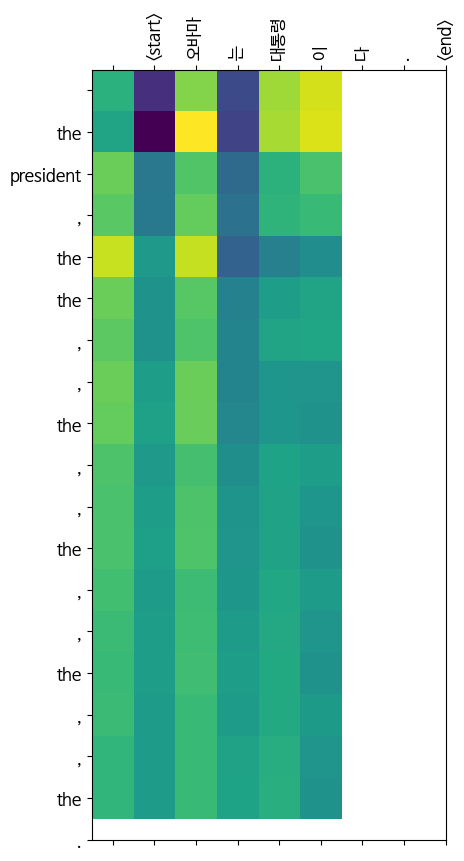

  * Best Val. Loss updated: 6.507
Epoch: 02 | Time: 3.0m 26s
	Current LR: 0.001000
	Train Loss: 6.240 | Train PPL: 512.942
	 Val. Loss: 6.507 |  Val. PPL: 669.612

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is the to the , , .


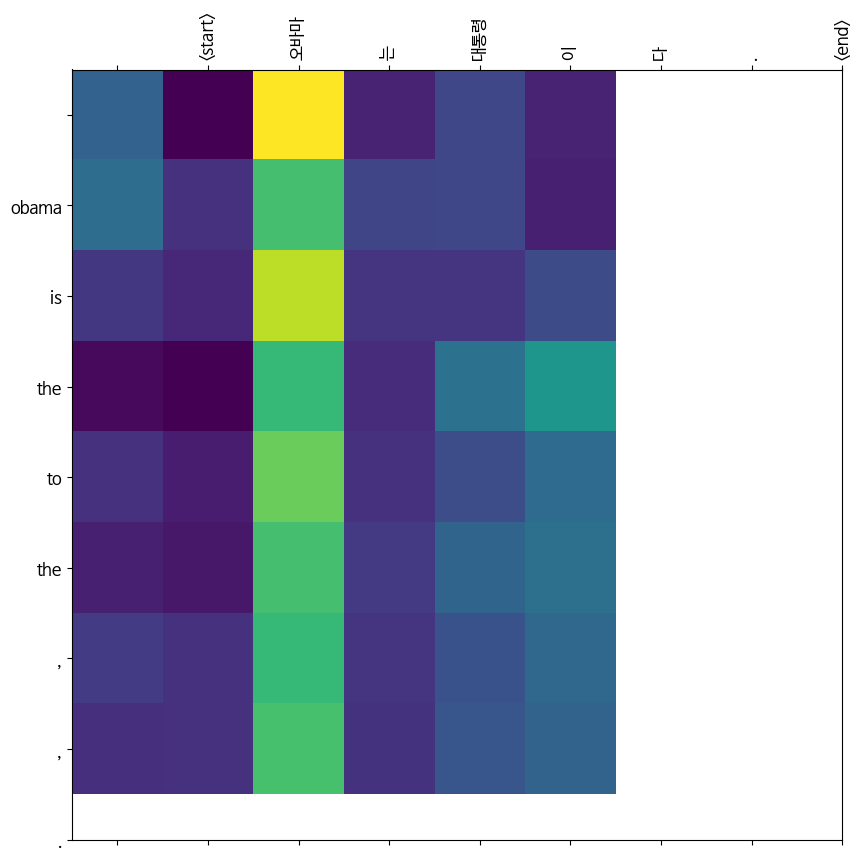

  * Best Val. Loss updated: 6.457
Epoch: 03 | Time: 3.0m 27s
	Current LR: 0.001000
	Train Loss: 6.052 | Train PPL: 425.074
	 Val. Loss: 6.457 |  Val. PPL: 637.046

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: i will be the . .


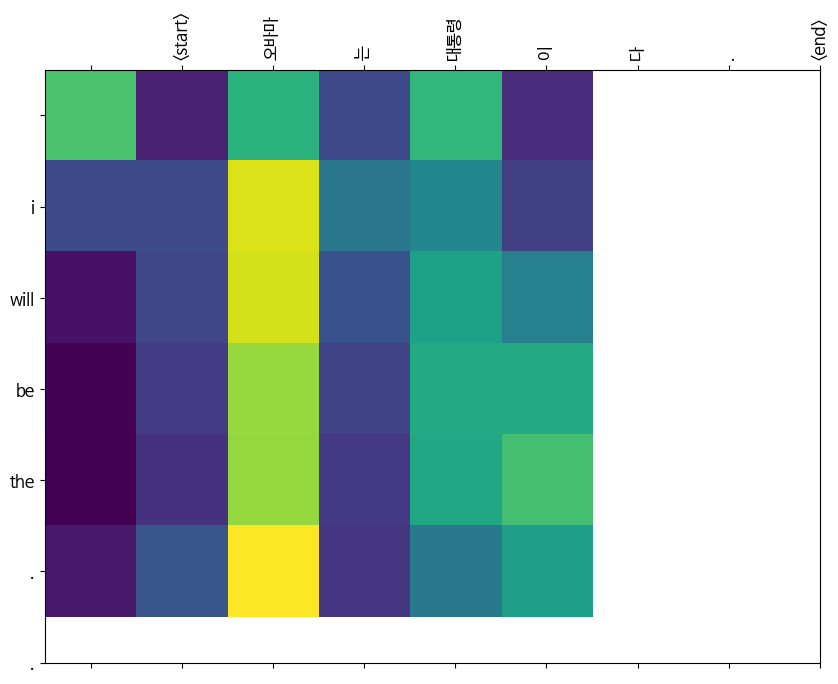

  * Best Val. Loss updated: 6.405
Epoch: 04 | Time: 3.0m 25s
	Current LR: 0.001000
	Train Loss: 5.930 | Train PPL: 376.313
	 Val. Loss: 6.405 |  Val. PPL: 604.698

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: i m . bush .


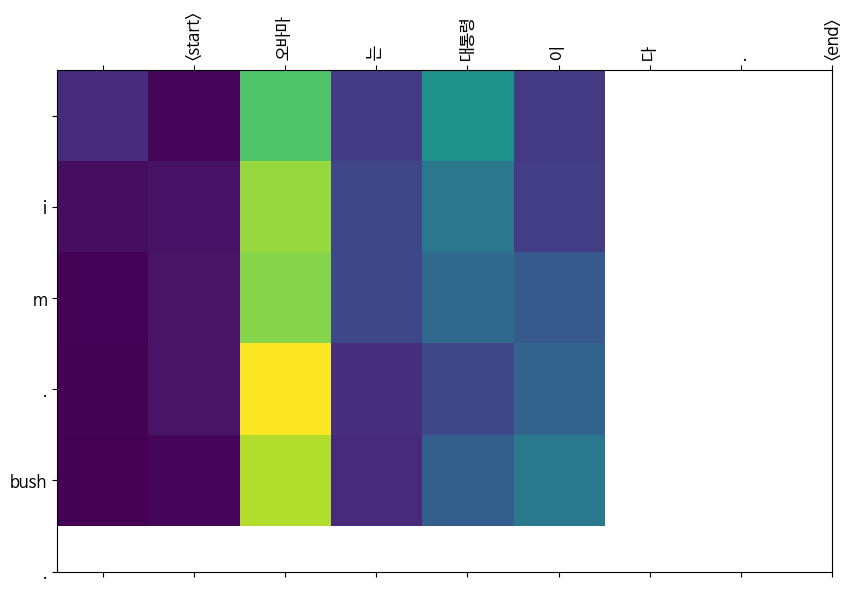

  * Early Stopping Counter: 1/3
Epoch: 05 | Time: 3.0m 26s
	Current LR: 0.001000
	Train Loss: 5.838 | Train PPL: 342.939
	 Val. Loss: 6.422 |  Val. PPL: 615.082

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: i m . bush , president bush , president bush .


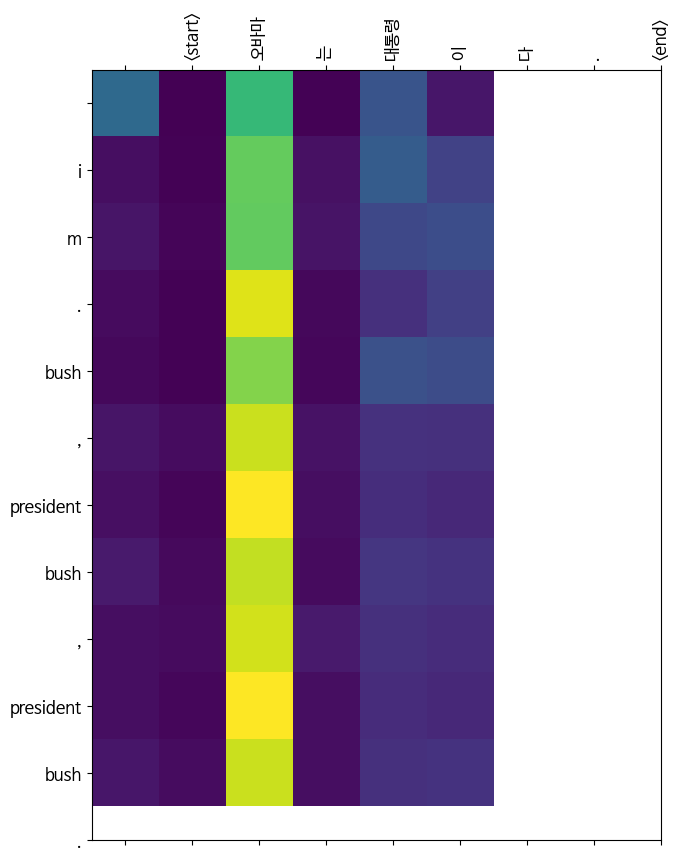

  * Best Val. Loss updated: 6.404
Epoch: 06 | Time: 3.0m 27s
	Current LR: 0.001000
	Train Loss: 5.769 | Train PPL: 320.289
	 Val. Loss: 6.404 |  Val. PPL: 604.253

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama s the , , obama .


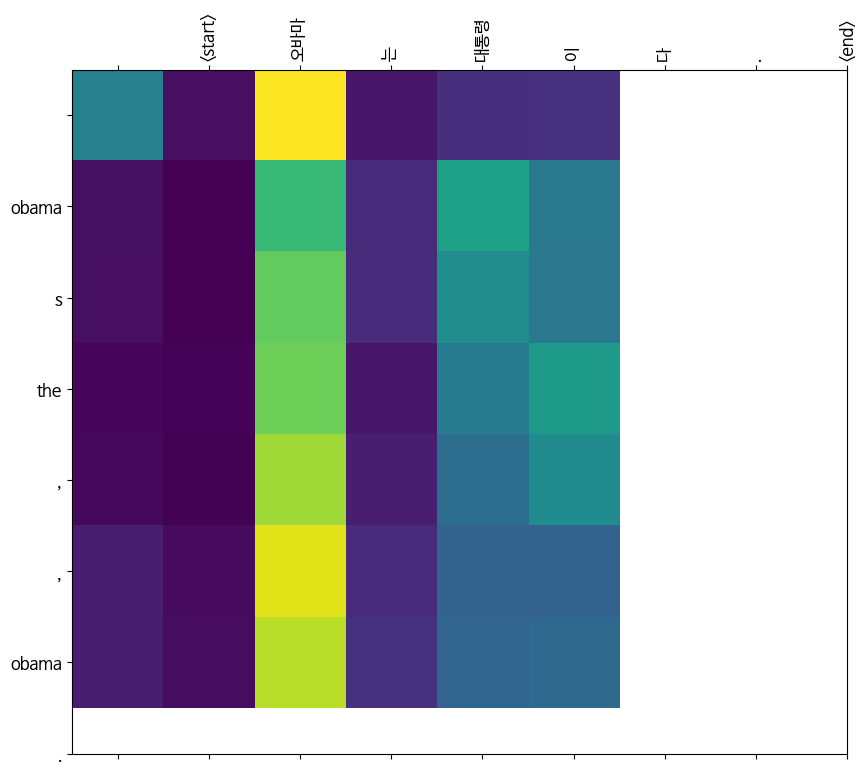

  * Best Val. Loss updated: 6.367
Epoch: 07 | Time: 3.0m 27s
	Current LR: 0.001000
	Train Loss: 5.707 | Train PPL: 300.968
	 Val. Loss: 6.367 |  Val. PPL: 582.188

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is the president , the president , the president .


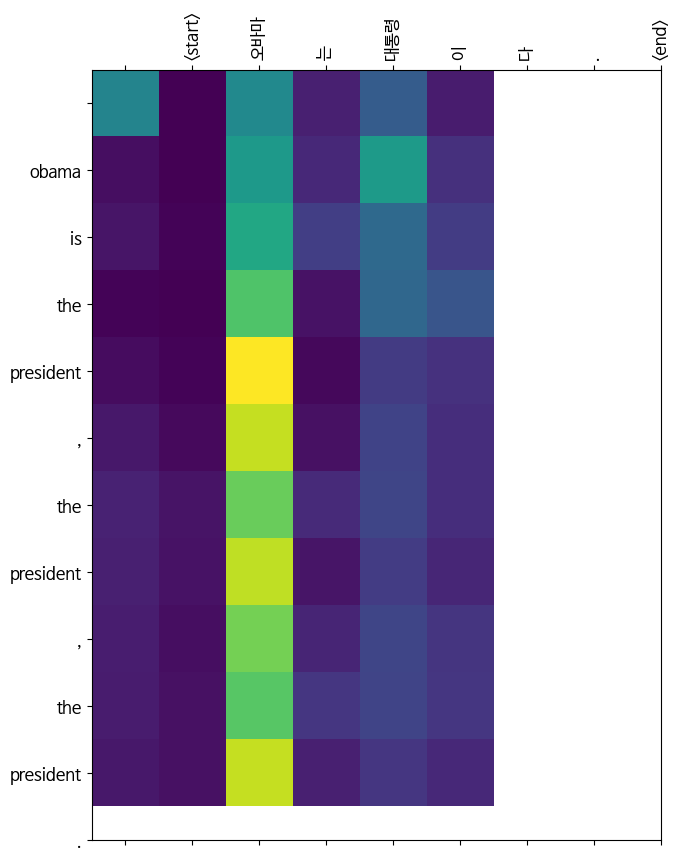

  * Best Val. Loss updated: 6.362
Epoch: 08 | Time: 3.0m 27s
	Current LR: 0.001000
	Train Loss: 5.655 | Train PPL: 285.578
	 Val. Loss: 6.362 |  Val. PPL: 579.489

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: i m . bush . .


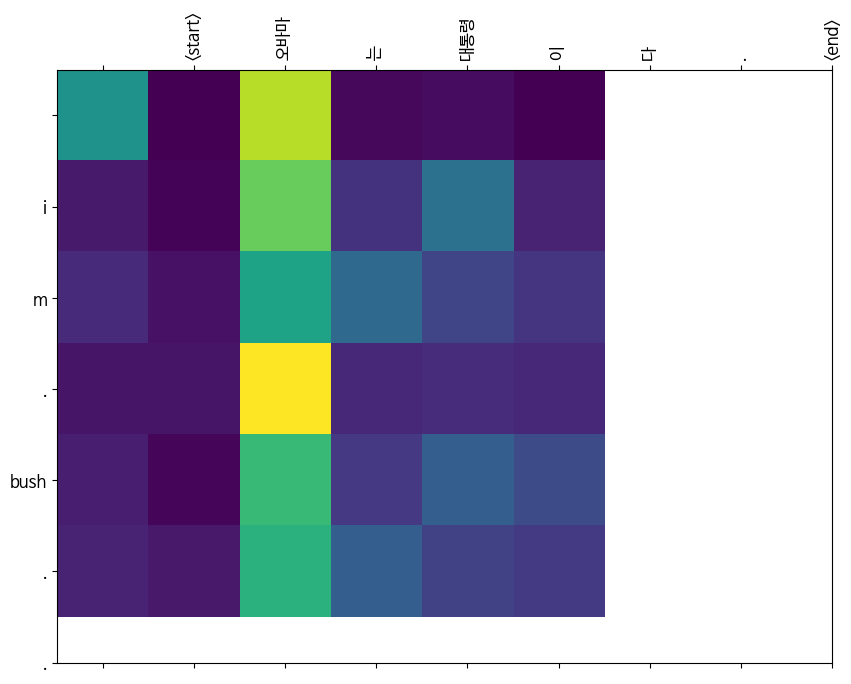

  * Best Val. Loss updated: 6.343
Epoch: 09 | Time: 3.0m 28s
	Current LR: 0.001000
	Train Loss: 5.611 | Train PPL: 273.370
	 Val. Loss: 6.343 |  Val. PPL: 568.403

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is the president , president bush is a president .


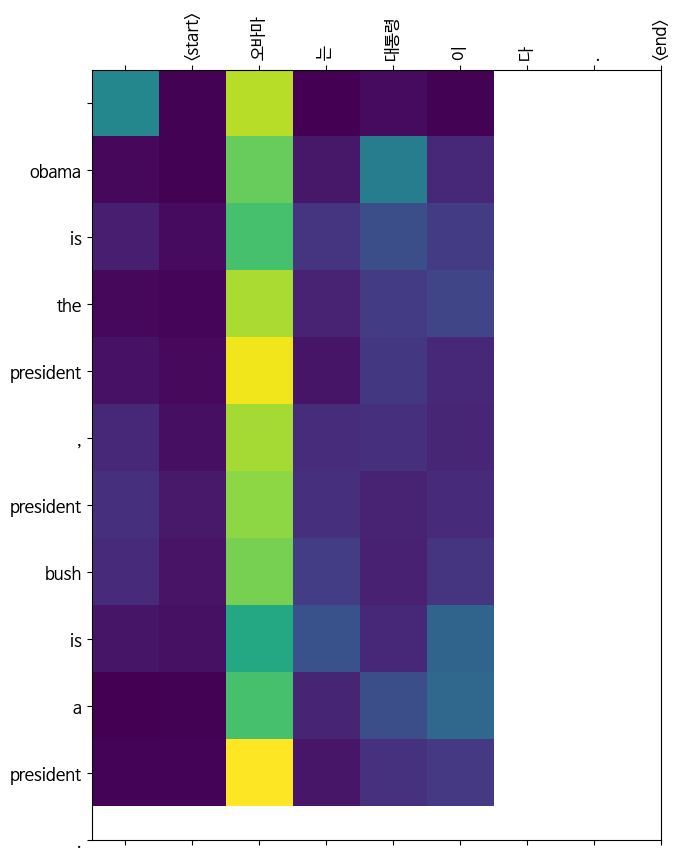

  * Early Stopping Counter: 1/3
Epoch: 10 | Time: 3.0m 27s
	Current LR: 0.001000
	Train Loss: 5.561 | Train PPL: 260.097
	 Val. Loss: 6.383 |  Val. PPL: 591.815

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is the president , the president , obama s president , president .


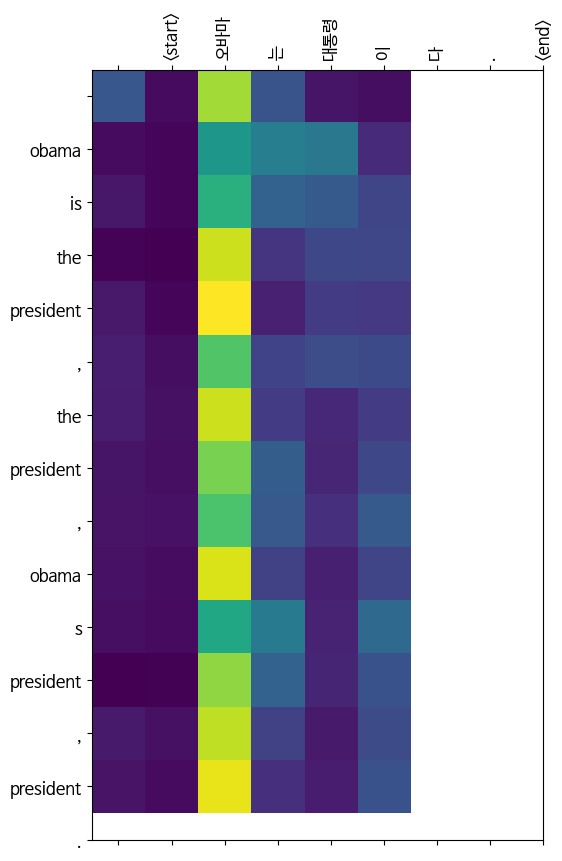

  * Early Stopping Counter: 2/3
Epoch: 11 | Time: 3.0m 28s
	Current LR: 0.000500
	Train Loss: 5.528 | Train PPL: 251.656
	 Val. Loss: 6.352 |  Val. PPL: 573.401

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is the president , the president .


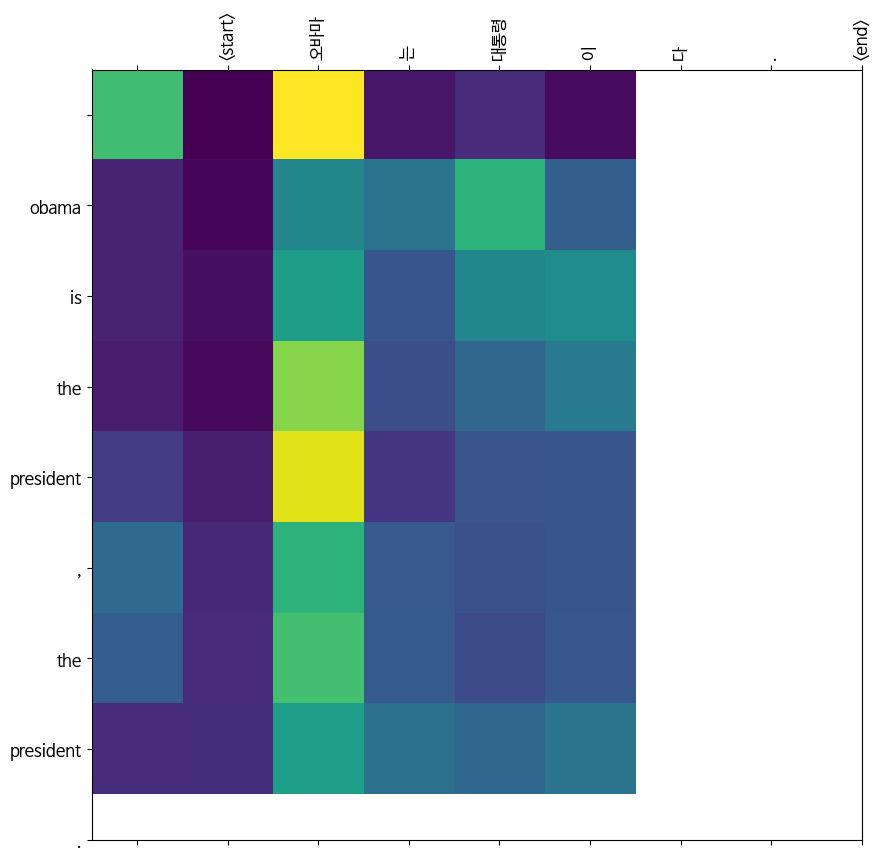

  * Best Val. Loss updated: 6.322
Epoch: 12 | Time: 3.0m 28s
	Current LR: 0.000500
	Train Loss: 5.440 | Train PPL: 230.549
	 Val. Loss: 6.322 |  Val. PPL: 556.961

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: i m . president , president bush said .


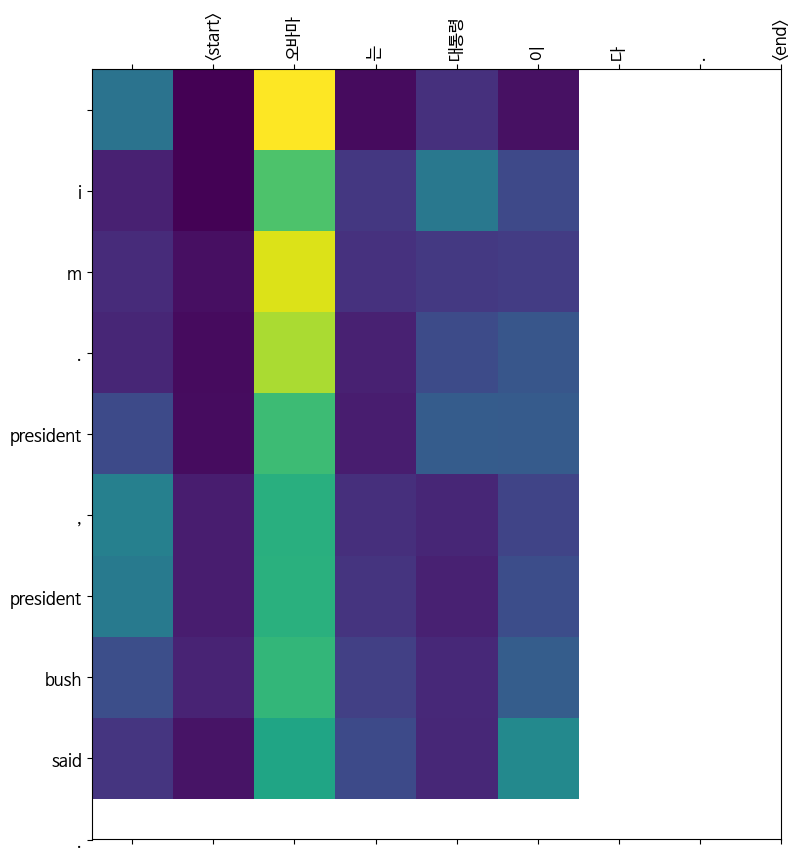

  * Early Stopping Counter: 1/3
Epoch: 13 | Time: 3.0m 27s
	Current LR: 0.000500
	Train Loss: 5.408 | Train PPL: 223.250
	 Val. Loss: 6.328 |  Val. PPL: 560.058

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is the president , president , president , president .


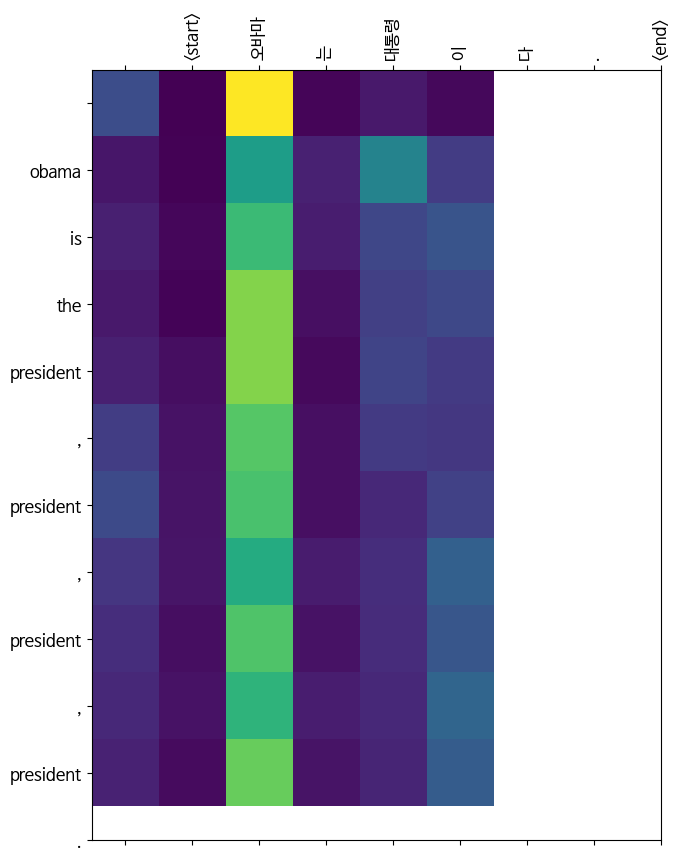

  * Best Val. Loss updated: 6.307
Epoch: 14 | Time: 3.0m 26s
	Current LR: 0.000500
	Train Loss: 5.391 | Train PPL: 219.494
	 Val. Loss: 6.307 |  Val. PPL: 548.392

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is , , president bush is a .


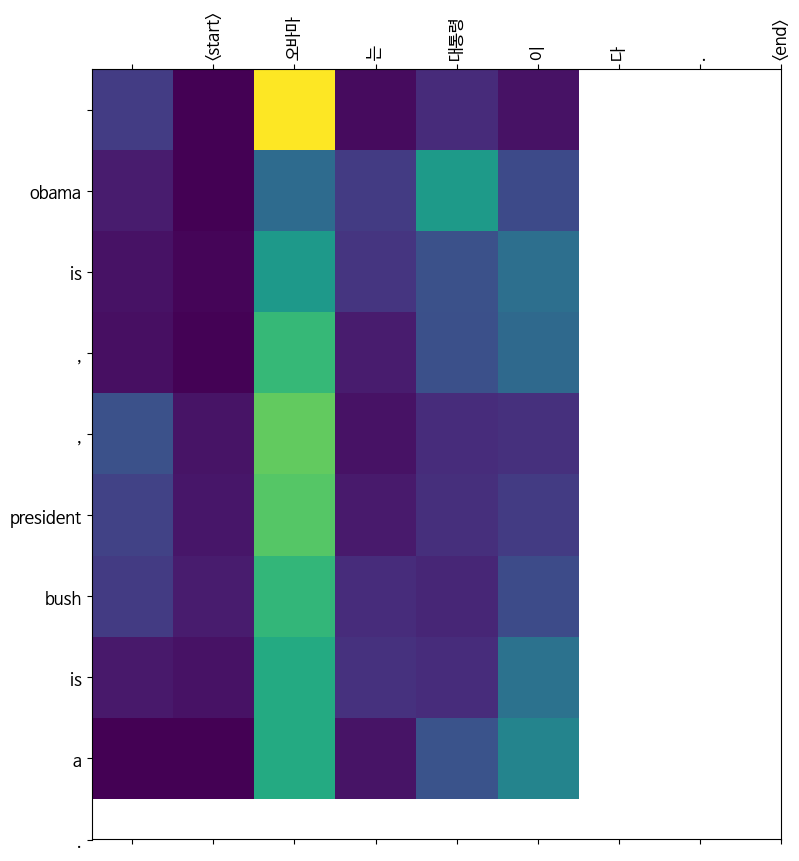

  * Early Stopping Counter: 1/3
Epoch: 15 | Time: 3.0m 26s
	Current LR: 0.000500
	Train Loss: 5.374 | Train PPL: 215.701
	 Val. Loss: 6.324 |  Val. PPL: 557.772

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is , , president , president bush is a .


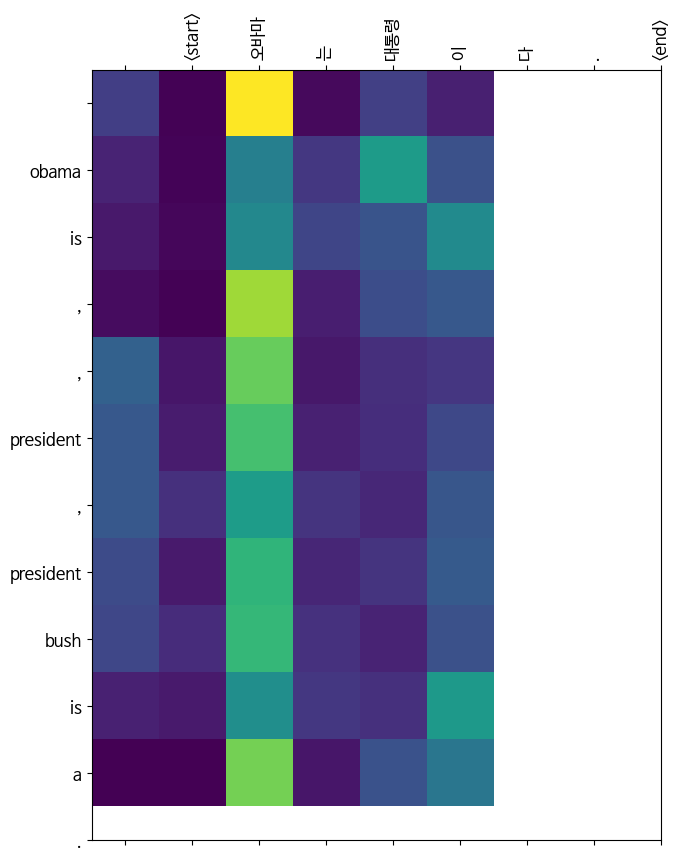

  * Early Stopping Counter: 2/3
Epoch: 16 | Time: 3.0m 26s
	Current LR: 0.000250
	Train Loss: 5.351 | Train PPL: 210.910
	 Val. Loss: 6.337 |  Val. PPL: 564.913

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is , , president bush s .


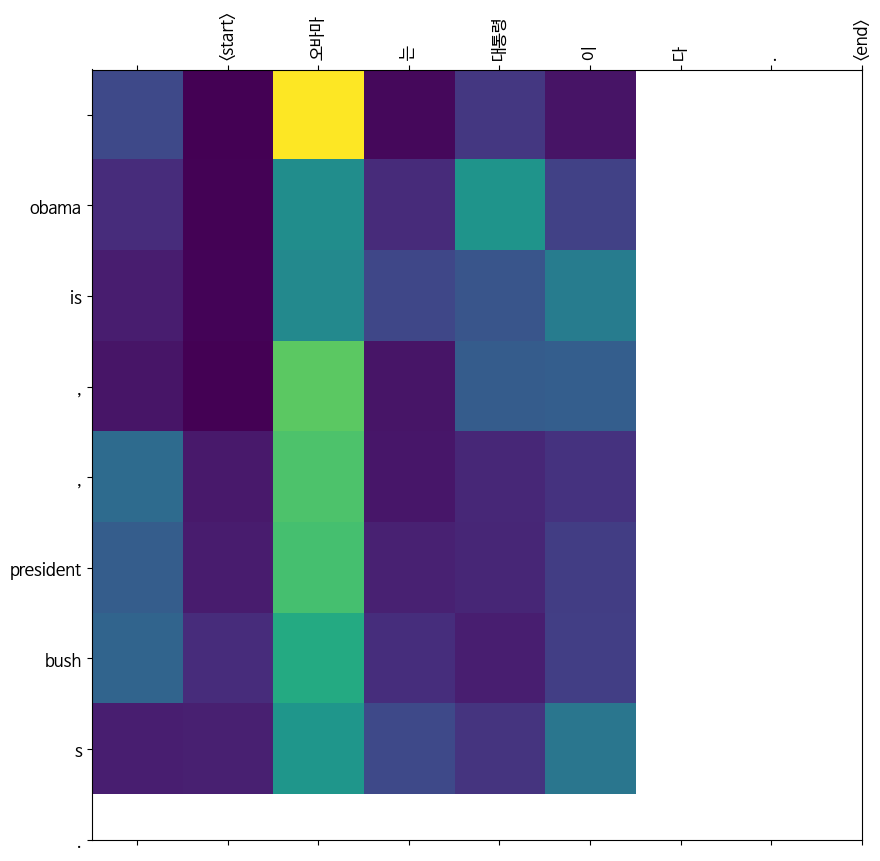

  * Early Stopping Counter: 3/3

[Early Stopping] Validation loss did not improve for 3 epochs. Stopping training...


In [12]:
# 하이퍼파라미터
N_EPOCHS = 100  # 최대 에포크 수 (Early Stopping으로 조기 종료됨)
CLIP = 1      # 그레이디언트 클리핑 값
PATIENCE = 3    # Early Stopping을 위한 patience (검증 손실이 개선되지 않는 에포크 수)

# 최적의 검증 손실 초기화
best_valid_loss = float('inf')
patience_counter = 0

attention_check_sentence = "오바마는 대통령이다."

# 에포크별 학습 루프
for epoch in range(N_EPOCHS):
    start_time = time.time()

    # 학습 및 검증 손실 계산
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_loader, criterion)

    # 검증 손실을 기반으로 학습률 조정
    scheduler.step(valid_loss)

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    # 검증 손실이 개선된 경우
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'translator-ko-en-v3.pt')
        patience_counter = 0
        print(f"  * Best Val. Loss updated: {best_valid_loss:.3f}")
    else:
        patience_counter += 1
        print(f"  * Early Stopping Counter: {patience_counter}/{PATIENCE}")

    # Early Stopping 조건 확인
    if patience_counter >= PATIENCE:
        print(f"\n[Early Stopping] Validation loss did not improve for {PATIENCE} epochs. Stopping training...")
        break

    # 현재 학습률 가져오기
    current_lr = optimizer.param_groups[0]['lr']

    # 에포크별 결과 출력
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs:.0f}s')
    # 학습률 출력
    print(f'\tCurrent LR: {current_lr:.6f}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f}')

    print("\n--- Checking Attention Map ---")
        
    translate_and_show_attention(
        attention_check_sentence,
        model,
        kor_word_to_idx,
        eng_idx_to_word,
        device
    )

    model.train()

## Step 4. 최종 테스트 및 번역 시각화

In [13]:
# 저장된 최적 모델 가중치 로드
model.load_state_dict(torch.load('translator-ko-en-v3.pt'))

# 테스트 데이터로 모델 평가
test_loss = evaluate(model, test_loader, criterion)

# 테스트 손실과 Perplexity 출력
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |')


| Test Loss: 6.358 | Test PPL: 577.362 |


In [15]:
def translate_with_beam_search(sentence, model, kor_word_to_idx, eng_idx_to_word, device, beam_width=5, max_len=50):
    model.eval()
    tokens = mecab.morphs(sentence)
    src_indexes = [kor_word_to_idx.get(t, kor_word_to_idx['<unk>']) for t in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)

    # 초기 후보 시퀀스: ['<start>'] + 확률(1.0)
    sequences = [[eng_word_to_idx['<start>']],]
    sequence_probs = [1.0]

    for _ in range(max_len):
        all_candidates = []
        for seq, prob in zip(sequences, sequence_probs):
            trg_tensor = torch.LongTensor([seq[-1]]).to(device)
            with torch.no_grad():
                output, hidden, _ = model.decoder(trg_tensor, hidden, encoder_outputs)
            top_k = torch.topk(output, beam_width, dim=1)
            for i in range(beam_width):
                next_token = top_k.indices[0][i].item()
                next_prob = torch.log(torch.softmax(top_k.values[0][i], dim=0)).item()
                candidate_seq = seq + [next_token]
                candidate_prob = prob + next_prob
                all_candidates.append((candidate_seq, candidate_prob))

        # 상위 beam_width개 후보만 유지
        sequences, sequence_probs = zip(*sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_width])
        sequences, sequence_probs = list(sequences), list(sequence_probs)

        # 모든 후보가 '<end>'로 끝나면 종료
        if all(seq[-1] == eng_word_to_idx['<end>'] for seq in sequences):
            break

    # 가장 확률이 높은 시퀀스 선택
    best_sequence = sequences[0]
    translation = [eng_idx_to_word.get(i, '<unk>') for i in best_sequence[1:-1]]  # '<start>'와 '<end>' 제거
    return ' '.join(translation)


Original: 오바마는 대통령이다.
Translated: obama is , , president bush is a .


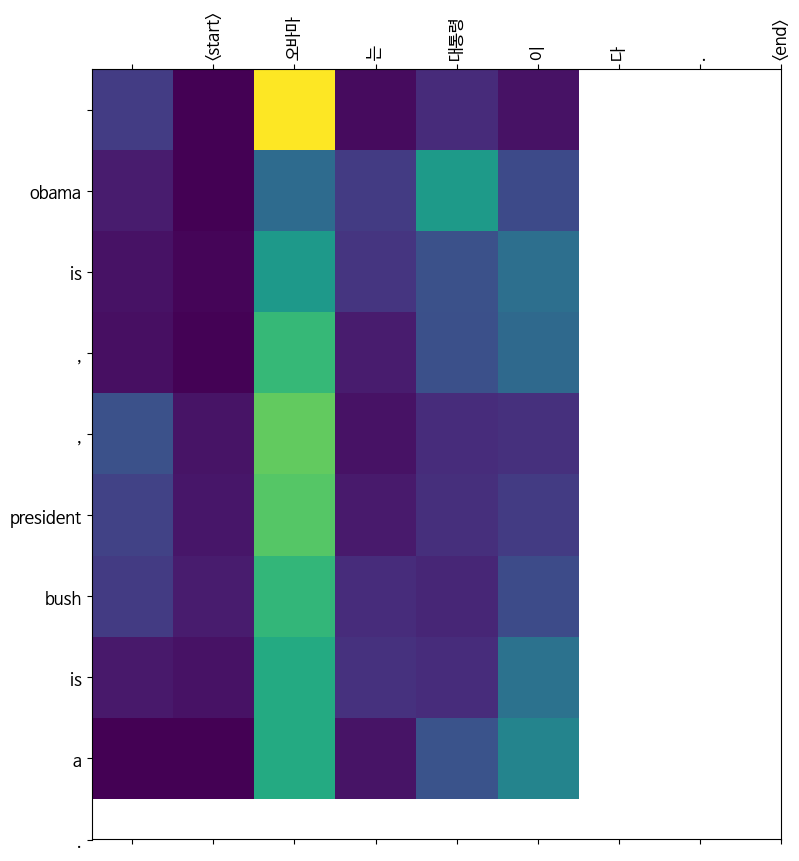


Original: 시민들은 도시 속에 산다.
Translated: the city of <unk> <unk> <unk> <unk> <unk> <unk> .


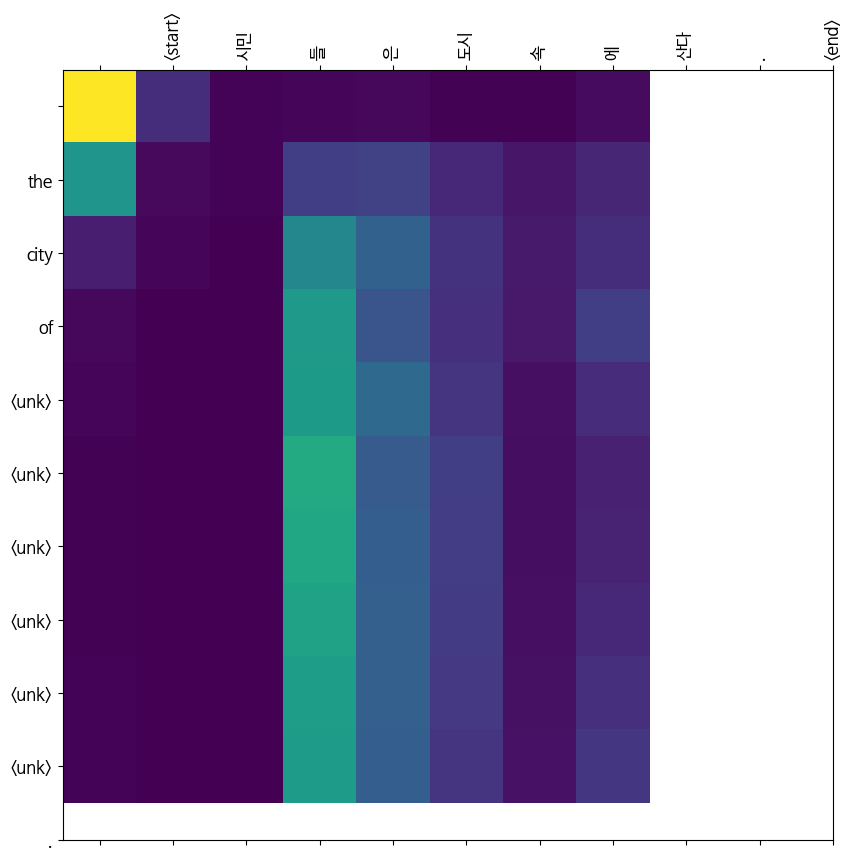


Original: 커피는 필요 없다.
Translated: the <unk> , , , , , , . . .


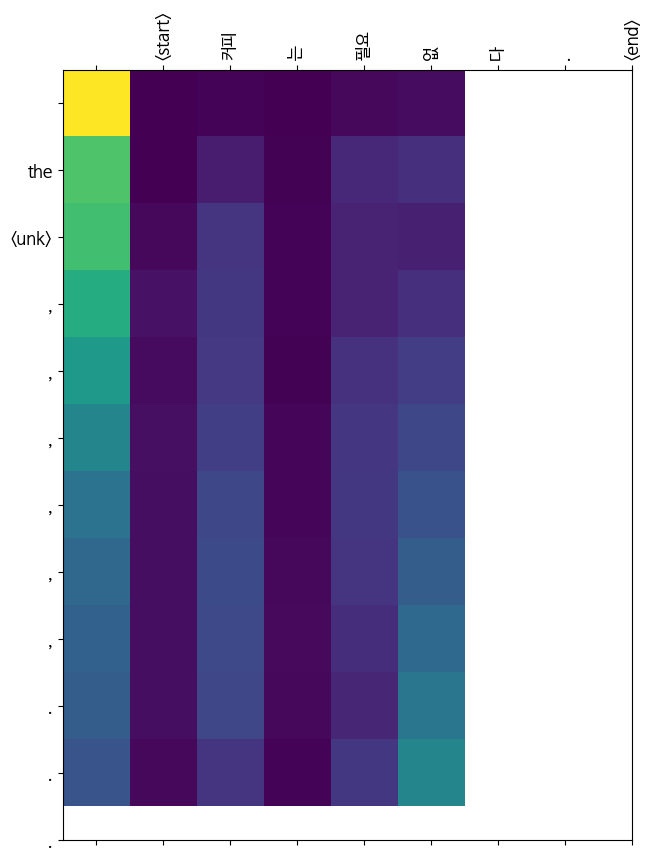


Original: 일곱 명의 사망자가 발생했다.
Translated: the least people were killed and wounded , the , the , the , the . .


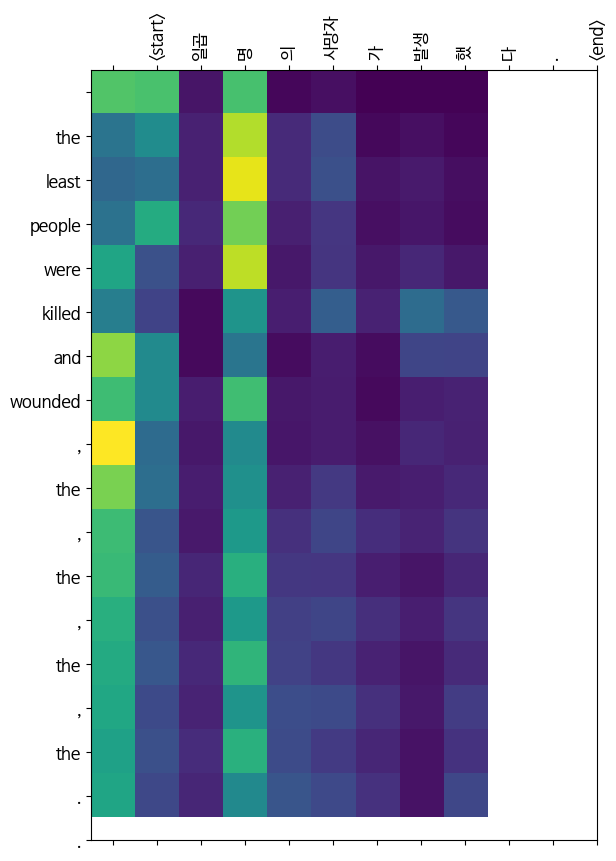

In [19]:
# 예문 번역 및 어텐션 시각화
example_sentences = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다."
]

for sentence in example_sentences:
    translate_and_show_attention(sentence, model, kor_word_to_idx, eng_idx_to_word, device)
    print()  # 예문별 구분선
    
